<a href="https://colab.research.google.com/github/ReinerJasin/ai-app-sys/blob/main/Week12_12224827.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A temperature-forecasting example




In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-15 07:28:26--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.225.200
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.225.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.8MB/s    in 0.9s    

2022-11-15 07:28:28 (13.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("/content/jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

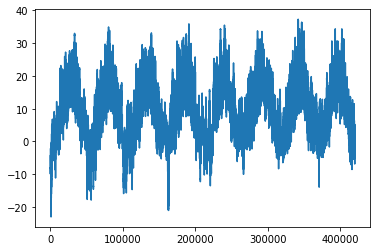

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

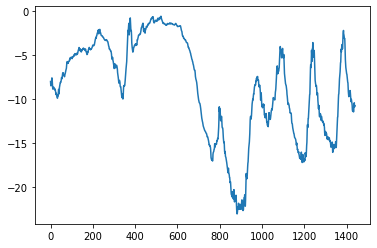

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Preparing the data

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
)

for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3


**Instantiating datasets for training, validation, and testing**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples
)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non machine-learning baseline

**Computing the common-sense baseline MAE**

In [12]:
def evaluate_naive_method(dataset):

  total_abs_err = 0.
  samples_seen = 0
  
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = "relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = callbacks
    )

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 46ms/step - loss: 11.7899 - mae: 2.6639 - val_loss: 13.1078 - val_mae: 2.8705
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 8.7297 - mae: 2.3250 - val_loss: 11.0875 - val_mae: 2.6316
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 8.0732 - mae: 2.2378 - val_loss: 10.1263 - val_mae: 2.5152
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 7.6460 - mae: 2.1788 - val_loss: 10.5672 - val_mae: 2.5738
Epoch 5/10
819/819 [==============================] - 38s 46ms/step - loss: 7.3428 - mae: 2.1362 - val_loss: 10.6362 - val_mae: 2.5686
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 7.1077 - mae: 2.1035 - val_loss: 10.4684 - val_mae: 2.5507
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 6.8993 - mae: 2.0735 - val_loss: 15.2945 - val_mae: 3.1131
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

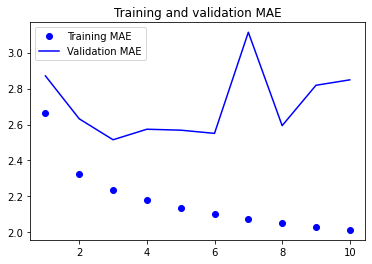

In [14]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, "b", label = "Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [15]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation = "relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation = "relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation = "relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = callbacks
    )

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 50ms/step - loss: 24.5149 - mae: 3.8745 - val_loss: 15.4986 - val_mae: 3.0879
Epoch 2/10
819/819 [==============================] - 39s 48ms/step - loss: 17.2528 - mae: 3.2791 - val_loss: 18.5774 - val_mae: 3.4594
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 15.4107 - mae: 3.1034 - val_loss: 15.8508 - val_mae: 3.1021
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 14.3133 - mae: 2.9956 - val_loss: 15.8296 - val_mae: 3.1040
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 13.5843 - mae: 2.9208 - val_loss: 16.2075 - val_mae: 3.1493
Epoch 6/10
819/819 [==============================] - 40s 48ms/step - loss: 12.9963 - mae: 2.8571 - val_loss: 17.0532 - val_mae: 3.2626
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 12.5057 - mae: 2.8017 - val_loss: 15.0555 - val_mae: 3.0323
Epoch 8/10
819/819 [============================

A first recurrent baseline

**A simple LSTM-based model**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = callbacks
    )

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 53ms/step - loss: 36.6824 - mae: 4.3640 - val_loss: 11.5084 - val_mae: 2.5978
Epoch 2/10
819/819 [==============================] - 43s 53ms/step - loss: 10.6082 - mae: 2.5337 - val_loss: 9.9649 - val_mae: 2.4538
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.6926 - mae: 2.4264 - val_loss: 9.5779 - val_mae: 2.4111
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 9.3451 - mae: 2.3811 - val_loss: 9.5980 - val_mae: 2.4031
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 9.1231 - mae: 2.3495 - val_loss: 9.6033 - val_mae: 2.3989
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9199 - mae: 2.3186 - val_loss: 9.7701 - val_mae: 2.4200
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.7614 - mae: 2.2947 - val_loss: 9.5853 - val_mae: 2.3936
Epoch 8/10
819/819 [==============================] - 43s 5

Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [17]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis = 0)


A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [18]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [21]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences = True)(inputs)
x = layers.SimpleRNN(16, return_sequences = True)(x)
outputs = layers.SimpleRNN(16)(x)

# Advanced use of recurrent neural networks

## Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout = 0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = val_dataset,
    callbacks = callbacks
    )

# model = keras.models.load_model("jena_lstm_dropout.keras")
# print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 332s 403ms/step - loss: 28.3577 - mae: 3.9176 - val_loss: 9.8720 - val_mae: 2.4486
Epoch 2/50
819/819 [==============================] - 330s 403ms/step - loss: 14.8436 - mae: 2.9959 - val_loss: 9.7376 - val_mae: 2.4270
Epoch 3/50
819/819 [==============================] - ETA: 0s - loss: 14.0271 - mae: 2.9035

KeyboardInterrupt: ignored

In [23]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout = 0.2, unroll = True)(inputs)

## Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout = 0.5, return_sequences = True)(inputs)
x = layers.GRU(32, recurrent_dropout = 0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = val_dataset,
    callbacks = callbacks
    )

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 602s 729ms/step - loss: 28.1388 - mae: 3.8742 - val_loss: 9.4320 - val_mae: 2.3698
Epoch 2/50
200/819 [======>.......................] - ETA: 7:02 - loss: 14.4347 - mae: 2.9443

KeyboardInterrupt: ignored

## Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset
    )

Epoch 1/10
819/819 [==============================] - 50s 57ms/step - loss: 25.7219 - mae: 3.6474 - val_loss: 10.9155 - val_mae: 2.5652
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 9.4739 - mae: 2.4015 - val_loss: 9.5002 - val_mae: 2.3978
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 8.6263 - mae: 2.2912 - val_loss: 9.3695 - val_mae: 2.3902
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 8.0620 - mae: 2.2148 - val_loss: 9.5986 - val_mae: 2.4137
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 7.7126 - mae: 2.1655 - val_loss: 9.5443 - val_mae: 2.3991
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 7.4014 - mae: 2.1221 - val_loss: 9.7880 - val_mae: 2.4231
Epoch 7/10
819/819 [==============================] - 47s 56ms/step - loss: 7.1263 - mae: 2.0849 - val_loss: 10.0117 - val_mae: 2.4318
Epoch 8/10
819/819 [==============================] - 46s 5